In [1]:
import numpy as np
import SimpleITK as sitk
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# DATA


## GET DATA

In [2]:
from glob import glob
from typing import  List

In [3]:
BUY_file_paths =  sorted(glob("./SEGMENTED/BUY/*.nii.gz"))  #68 files
EAT_file_paths =  sorted(glob("./SEGMENTED/EAT/*.nii.gz"))  #85 files
GAMBLE_file_paths =  sorted(glob("./SEGMENTED/GAMBLE/*.nii.gz")) #7 files
SEX_file_paths =  sorted(glob("./SEGMENTED/SEX/*.nii.gz"))  #42 files

PD_file_paths =  sorted(glob("./SEGMENTED/PD/*.nii.gz"))  #100 files

In [4]:
BUY_file_paths =  sorted(glob("./PREPROCESSED/BUY/*.nii.gz"))  #42 files
EAT_file_paths =  sorted(glob("./PREPROCESSED/EAT/*.nii.gz"))  #81 files
GAMBLE_file_paths =  []#sorted(glob("./PREPROCESSED/GAMBLE/*.nii.gz")) #7 files
SEX_file_paths =  []#sorted(glob("./PREPROCESSED/SEX/*.nii.gz"))  #22 files

PD_file_paths =  sorted(glob("./PREPROCESSED/PD/*.nii.gz"))  #116 files

In [5]:
print(len(BUY_file_paths), BUY_file_paths[:3])
print(len(EAT_file_paths), EAT_file_paths[:3])
print(len(GAMBLE_file_paths), GAMBLE_file_paths[:3])
print(len(SEX_file_paths), SEX_file_paths[:3])

print(len(PD_file_paths), PD_file_paths[:3])

42 ['./PREPROCESSED/BUY\\3018.nii.gz', './PREPROCESSED/BUY\\3062.nii.gz', './PREPROCESSED/BUY\\3168.nii.gz']
81 ['./PREPROCESSED/EAT\\3002.nii.gz', './PREPROCESSED/EAT\\3023.nii.gz', './PREPROCESSED/EAT\\3062.nii.gz']
0 []
0 []
116 ['./PREPROCESSED/PD\\3006.nii.gz', './PREPROCESSED/PD\\3012.nii.gz', './PREPROCESSED/PD\\3014.nii.gz']


In [6]:
print(len(BUY_file_paths) + len(EAT_file_paths) + len(GAMBLE_file_paths) + len(SEX_file_paths))
print(len(PD_file_paths))

123
116


## SPLIT DATA

In [7]:
X_dataset = []
y_dataset = []

X_dataset.extend(PD_file_paths), y_dataset.extend([1] * len(PD_file_paths))
X_dataset.extend(BUY_file_paths), y_dataset.extend([2] * len(BUY_file_paths))
X_dataset.extend(EAT_file_paths), y_dataset.extend([3] * len(EAT_file_paths))
#X_dataset.extend(GAMBLE_file_paths), y_dataset.extend([4] * len(GAMBLE_file_paths))
#X_dataset.extend(SEX_file_paths), y_dataset.extend([5] * len(SEX_file_paths))

(None, None)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2, stratify=y_dataset)

In [8]:
print("Dataset:", len(X_dataset), len(y_dataset))
print("Train:", len(X_train), len(y_train))
print("Test:", len(X_test), len(y_test))

Dataset: 239 239
Train: 191 191
Test: 48 48


## PREPROSSESING

In [9]:
def get_category(category, is_binary = True):
  result = np.zeros(2 if is_binary else 5)
  if is_binary:
    return 1 if category == 1 else 0
  elif category == 1:
    result[0] = 1
  else:
    result[category-1] = 1
  return result

In [10]:
def get_categories(y_data):
  categories = None
  is_first = True
  for category in y_data:
    if is_first:
      categories = np.array([get_category(category)])
      is_first = False
    else:
      categories = np.concatenate((categories,[get_category(category)]))
  return categories

In [11]:
print(get_category(5, True), get_category(5, False))
print(get_category(1, True), get_category(1, False))

0 [0. 0. 0. 0. 1.]
1 [1. 0. 0. 0. 0.]


## 3D All Brain

In [12]:
import cv2
from scipy import ndimage
dimension = 100
def get_slices_3d_all(path, category):
    img = sitk.ReadImage(path, sitk.sitkFloat64)
    arr = sitk.GetArrayFromImage(img)
    
    slice = arr[30:130, : , :]
    
    arr = np.zeros([slice.shape[0], dimension,dimension])
    
    count = 0
    for i in range(arr.shape[0]):
        if arr[i:,:].max() != 0.0:
            print(count)
        arr[i, : , :] = cv2.resize(slice[i, : , :], (dimension, dimension), interpolation=cv2.INTER_CUBIC)
        arr[arr<0] = 0
        count += 1
    
    slices = np.array([arr])
    slices = slices.reshape(1,arr.shape[0], arr.shape[1], arr.shape[2], 1)
    slices_cat = np.array([get_category(category)])
    
    rotated = ndimage.rotate(arr, 45, reshape=False, axes=(1, 2))
    rotated = rotated.reshape(1,arr.shape[0], arr.shape[1], arr.shape[2], 1)
    slices = np.concatenate((slices, rotated))
    slices_cat = np.concatenate((slices_cat, [get_category(category)]))
    
    return slices, slices_cat

In [13]:
def get_slices_per_group_3d_all(paths, categories):
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        try:
            if i == 0:
                group, group_cat = get_slices_3d_all(path, categories[i])
            else:
                new_group, new_group_cat = get_slices_3d_all(path, categories[i])
                group = np.concatenate((group, new_group))
                group_cat = np.concatenate((group_cat, new_group_cat))

            print("-> [%d/%d] Image processed." %(count,len(paths)))
            count+=1
        except:
            print("Error in", path)
    return group, group_cat

In [14]:
#test with one image
slices, slices_cat = get_slices_3d_all(X_dataset[11], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(2, 100, 100, 100, 1)
(2,)


In [15]:
slices, slices_cat = get_slices_per_group_3d_all(X_dataset[:3], y_dataset[:3])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Image processed.
-> [2/3] Image processed.
-> [3/3] Image processed.
(6, 100, 100, 100, 1)
(6,)


3854.9990418601315


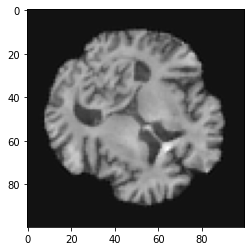

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

i = 50
print(slices[0,i,:,:,0].max())
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(slices[5,i,:,:,0], cmap="gray")
plt.show()

## 3D

In [17]:
import cv2

dimension = 120
x = 32
def get_slices_3d(path, category):
    img = sitk.ReadImage(path, sitk.sitkFloat64)
    arr = sitk.GetArrayFromImage(img)

    #normalize the matrix, numbers between 0.0 - 1.0
    #arr = arr / arr.max()
    
    slice = arr[68 - x :68,115:200,30:150]
    
    arr = np.zeros([x, dimension,dimension])
    
    for i in range(arr.shape[0]):
        arr[i, : , :] = cv2.resize(slice[i, : , :], (dimension, dimension), interpolation=cv2.INTER_CUBIC)
    
    slices = np.array([arr])
    slices = slices.reshape(1,arr.shape[0], arr.shape[1], arr.shape[2], 1)
    slices_cat = np.array([get_category(category)])
    
    return slices, slices_cat

In [18]:
def get_slices_per_group_3d(paths, categories):
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        if i == 0:
            group, group_cat = get_slices_3d(path, categories[i])
        else:
            new_group, new_group_cat = get_slices_3d(path, categories[i])
            group = np.concatenate((group, new_group))
            group_cat = np.concatenate((group_cat, new_group_cat))

        print("-> [%d/%d] Image processed." %(count,len(paths)))
        count+=1
    return group, group_cat

In [19]:
#test with one image
slices, slices_cat = get_slices_3d(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(1, 32, 120, 120, 1)
(1,)


In [20]:
slices, slices_cat = get_slices_per_group_3d(X_dataset[:3], y_dataset[:3])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Image processed.
-> [2/3] Image processed.
-> [3/3] Image processed.
(3, 32, 120, 120, 1)
(3,)


## AXIAL (3 channels)
arr[ xxx , : , : ] axial

In [21]:
import cv2

SLICE_NUMBER = 50
dim = 224
def get_slices_axial_3c(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)
  arr = arr[49:68,115:200,30:150]

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[arr.shape[0] - i -1, : , : ]
    slice = cv2.resize(slice, (dim, dim), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
        slice = cv2.merge((slice,slice,slice))
        if count == 0:
            slices = np.array([slice])
            slices_cat = np.array([get_category(category)])
        if count < SLICE_NUMBER:
            slices = np.concatenate((slices,[slice]))
            slices_cat = np.concatenate((slices_cat,[get_category(category)]))
        count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [22]:
def get_slices_per_group_axial_3c(paths, categories):
    
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        if i == 0:
            group, group_cat = get_slices_axial_3c(path, categories[i])
        else:
            try:
                new_group, new_group_cat = get_slices_axial_3c(path, categories[i])
                group = np.concatenate((group, new_group))
                group_cat = np.concatenate((group_cat, new_group_cat))
            except:
                print('error')

        print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
        count+=1
    return group, group_cat

In [23]:
#test with one image
i = 3
slices, slices_cat = get_slices_per_group_axial_3c(X_dataset[0:i], y_dataset[0:i])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Slices processed 20.
-> [2/3] Slices processed 40.
-> [3/3] Slices processed 60.
(60, 224, 224, 3)
(60,)


## AXIAL
arr[ xxx , : , : ] axial

In [24]:
import cv2

SLICE_NUMBER = 20
def get_slices_axial(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)
    
  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()
  arr = arr[49:68,115:200,30:150]
  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[arr.shape[0] - i -1, : , : ]
    slice = cv2.resize(slice, (120, 120), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      if count < SLICE_NUMBER:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [25]:
def get_slices_per_group_axial(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_axial(path, categories[i])
    else:
        try:
          new_group, new_group_cat = get_slices_axial(path, categories[i])
          group = np.concatenate((group, new_group))
          group_cat = np.concatenate((group_cat, new_group_cat))
        except:
            print("error")
    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [26]:
#test with one image
slices, slices_cat = get_slices_axial(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(20, 120, 120)
(20,)


## CORONAL
arr[ : , xxx , : ] coronal 

In [27]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_coronal(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()
  arr = arr = arr[49:68,115:200,30:150]

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, i , : ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [28]:
def get_slices_per_group_coronal(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_coronal(path, categories[i])
    else:
        try:
          new_group, new_group_cat = get_slices_coronal(path, categories[i])
          group = np.concatenate((group, new_group))
          group_cat = np.concatenate((group_cat, new_group_cat))
        except:
            print("error")

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [29]:
#test with one image
slices, slices_cat = get_slices_coronal(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(19, 224, 224)
(19,)


## SAGITAL
arr[ : , : , xxx ] sagital 

In [30]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_sagital(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()
  arr = arr = arr[49:68,115:200,30:150]

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, : , i ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [31]:
def get_slices_per_group_sagital(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_sagital(path, categories[i])
    else:
        try:
          new_group, new_group_cat = get_slices_coronal(path, categories[i])
          group = np.concatenate((group, new_group))
          group_cat = np.concatenate((group_cat, new_group_cat))
        except:
            print("error")
    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [32]:
#test with one image
slices, slices_cat = get_slices_sagital(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(19, 224, 224)
(19,)


# MODEL (BINARY)

## Axial (Enssemble)

In [33]:
import os
import numpy as np
np.random.seed(777)
import math
import tensorflow as tf
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [35]:
X_dataset_3c, y_dataset_3c = get_slices_per_group_axial_3c(X_dataset, y_dataset)

-> [1/239] Slices processed 20.
-> [2/239] Slices processed 40.
-> [3/239] Slices processed 60.
-> [4/239] Slices processed 80.
-> [5/239] Slices processed 100.
-> [6/239] Slices processed 120.
-> [7/239] Slices processed 140.
-> [8/239] Slices processed 160.
-> [9/239] Slices processed 180.
-> [10/239] Slices processed 200.
-> [11/239] Slices processed 220.
-> [12/239] Slices processed 240.
-> [13/239] Slices processed 260.
-> [14/239] Slices processed 280.
-> [15/239] Slices processed 300.
-> [16/239] Slices processed 320.
-> [17/239] Slices processed 340.
-> [18/239] Slices processed 360.
-> [19/239] Slices processed 380.
-> [20/239] Slices processed 400.
-> [21/239] Slices processed 420.
-> [22/239] Slices processed 440.
-> [23/239] Slices processed 460.
-> [24/239] Slices processed 480.
-> [25/239] Slices processed 500.
-> [26/239] Slices processed 520.
-> [27/239] Slices processed 540.
-> [28/239] Slices processed 560.
-> [29/239] Slices processed 580.
-> [30/239] Slices processe

-> [226/239] Slices processed 3414.
-> [227/239] Slices processed 3432.
error
-> [228/239] Slices processed 3432.
error
-> [229/239] Slices processed 3432.
error
-> [230/239] Slices processed 3432.
error
-> [231/239] Slices processed 3432.
-> [232/239] Slices processed 3440.
-> [233/239] Slices processed 3450.
-> [234/239] Slices processed 3463.
-> [235/239] Slices processed 3469.
-> [236/239] Slices processed 3477.
-> [237/239] Slices processed 3490.
error
-> [238/239] Slices processed 3490.
error
-> [239/239] Slices processed 3490.


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dataset_3c, y_dataset_3c, test_size = 0.2, stratify=y_dataset_3c)

In [102]:
X_axial3c_train, y_axial3c_train = get_slices_per_group_axial_3c(X_train[:100], y_train[:100])

-> [1/100] Slices processed 20.
-> [2/100] Slices processed 40.
-> [3/100] Slices processed 60.
-> [4/100] Slices processed 80.
-> [5/100] Slices processed 100.
-> [6/100] Slices processed 120.
-> [7/100] Slices processed 140.
-> [8/100] Slices processed 160.
-> [9/100] Slices processed 180.
-> [10/100] Slices processed 200.
-> [11/100] Slices processed 220.
-> [12/100] Slices processed 240.
-> [13/100] Slices processed 260.
-> [14/100] Slices processed 280.
-> [15/100] Slices processed 300.
-> [16/100] Slices processed 320.
-> [17/100] Slices processed 340.
-> [18/100] Slices processed 360.
-> [19/100] Slices processed 380.
-> [20/100] Slices processed 400.
-> [21/100] Slices processed 420.
-> [22/100] Slices processed 440.
-> [23/100] Slices processed 460.
-> [24/100] Slices processed 480.
-> [25/100] Slices processed 500.
-> [26/100] Slices processed 520.
-> [27/100] Slices processed 540.
-> [28/100] Slices processed 560.
-> [29/100] Slices processed 580.
-> [30/100] Slices processe

In [35]:
X_axial3c_test, y_axial3c_test = get_slices_per_group_axial_3c(X_test[1:], y_test[1:])

-> [1/47] Slices processed 20.
-> [2/47] Slices processed 40.
-> [3/47] Slices processed 60.
error
-> [4/47] Slices processed 60.
-> [5/47] Slices processed 66.
-> [6/47] Slices processed 86.
-> [7/47] Slices processed 106.
-> [8/47] Slices processed 126.
-> [9/47] Slices processed 146.
-> [10/47] Slices processed 166.
-> [11/47] Slices processed 186.
error
-> [12/47] Slices processed 186.
-> [13/47] Slices processed 199.
-> [14/47] Slices processed 219.
error
-> [15/47] Slices processed 219.
-> [16/47] Slices processed 239.
-> [17/47] Slices processed 259.
error
-> [18/47] Slices processed 259.
-> [19/47] Slices processed 279.
-> [20/47] Slices processed 299.
-> [21/47] Slices processed 317.
-> [22/47] Slices processed 320.
-> [23/47] Slices processed 340.
-> [24/47] Slices processed 348.
-> [25/47] Slices processed 368.
-> [26/47] Slices processed 388.
-> [27/47] Slices processed 408.
-> [28/47] Slices processed 428.
-> [29/47] Slices processed 448.
-> [30/47] Slices processed 468.
-

In [104]:
print(X_axial3c_train.shape, y_axial3c_train.shape)
print(X_axial3c_test.shape, y_axial3c_test.shape)

(1980, 224, 224, 3) (1980,)
(964, 224, 224, 3) (964,)


In [36]:
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
batch_size = 10
epochs = 1000
dropout_rate = 0.2
num_classes = 1

In [50]:
from tensorflow.keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model =VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor,outputs=predictions)

In [51]:
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model1=NASNetMobile(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model4=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

x4 = base_model4.output
x4 = GlobalAveragePooling2D()(x4)

merge = concatenate([x1, x2, x3 , x4])
predictions = Dense(1, activation='sigmoid')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

c:\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
checkpoint = ModelCheckpoint("vgg19_axial3c_18012022_1031.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_reduce, es_callback, checkpoint],
                    validation_split=0.20,
                    verbose= 2)

Epoch 1/1000


In [ ]:
model.

In [54]:
bottleneck_final_model = Model(inputs=model.input, outputs=merge)

In [55]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [122]:
batch_size = 10
epochs = 1000
dropout_rate = 0.2

model = Sequential()
model.add(Flatten(input_shape=X_axial3c_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

checkpoint = ModelCheckpoint("vgg19_axial3c_15022022_01231.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)
history = model.fit(X_axial3c_train, y_axial3c_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_reduce, es_callback, checkpoint],
                    validation_split=0.20,
                    verbose= 2)

Epoch 1/1000
159/159 - 47s - loss: 9.8581 - accuracy: 0.3535 - val_loss: 7.5476 - val_accuracy: 0.5051

Epoch 00001: val_accuracy improved from -inf to 0.50505, saving model to vgg19_axial3c_15022022_01231.h5
Epoch 2/1000
159/159 - 35s - loss: 9.8581 - accuracy: 0.3535 - val_loss: 7.5476 - val_accuracy: 0.5051

Epoch 00002: val_accuracy did not improve from 0.50505
Epoch 3/1000
159/159 - 35s - loss: 9.8581 - accuracy: 0.3535 - val_loss: 7.5476 - val_accuracy: 0.5051

Epoch 00003: val_accuracy did not improve from 0.50505
Epoch 4/1000
159/159 - 35s - loss: 9.8581 - accuracy: 0.3535 - val_loss: 7.5476 - val_accuracy: 0.5051

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00004: val_accuracy did not improve from 0.50505
Epoch 5/1000
159/159 - 35s - loss: 9.8581 - accuracy: 0.3535 - val_loss: 7.5476 - val_accuracy: 0.5051

Epoch 00005: val_accuracy did not improve from 0.50505
Epoch 6/1000
159/159 - 35s - loss: 9.8581 - accuracy: 0.3535 - val_loss: 7

In [111]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               38535424  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 38,535,681
Trainable params: 38,535,681
Non-trainable params: 0
_________________________________________________________________


In [112]:
preds = model.predict(X_axial3c_test)

predictions = [(0 if i <0.5 else 1) for i in preds]
cm = confusion_matrix(y_pred=predictions, y_true=y_axial3c_test)

print('Accuracy {}'.format(accuracy_score(y_true=y_axial3c_test, y_pred=predictions)))

Accuracy 0.5985477178423236


In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = ['parkinson', "parkinson + ICD"]

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_marix.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [ ]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
plt.savefig('model_acc.png', bbox_inches='tight', dpi = 100) 

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()
plt.savefig('model_pogress.png', bbox_inches='tight', dpi = 100) 

plt.figure()
N = len(history.history['accuracy'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('loss.png', bbox_inches='tight', dpi = 100) 

## 3D all brain

In [19]:
X_3d_all_train, y_3d_all_train = get_slices_per_group_3d_all(X_train, y_train)

-> [1/191] Image processed.
-> [2/191] Image processed.
-> [3/191] Image processed.
-> [4/191] Image processed.
-> [5/191] Image processed.
-> [6/191] Image processed.
-> [7/191] Image processed.
-> [8/191] Image processed.
-> [9/191] Image processed.
-> [10/191] Image processed.
-> [11/191] Image processed.
-> [12/191] Image processed.
-> [13/191] Image processed.
-> [14/191] Image processed.
-> [15/191] Image processed.
-> [16/191] Image processed.
-> [17/191] Image processed.
-> [18/191] Image processed.
-> [19/191] Image processed.
-> [20/191] Image processed.
-> [21/191] Image processed.
-> [22/191] Image processed.
-> [23/191] Image processed.
-> [24/191] Image processed.
-> [25/191] Image processed.
-> [26/191] Image processed.
-> [27/191] Image processed.
-> [28/191] Image processed.
-> [29/191] Image processed.
-> [30/191] Image processed.
-> [31/191] Image processed.
-> [32/191] Image processed.
-> [33/191] Image processed.
-> [34/191] Image processed.
-> [35/191] Image proce

In [20]:
X_3d_all_test, y_3d_all_test = get_slices_per_group_3d_all(X_test, y_test)

-> [1/48] Image processed.
-> [2/48] Image processed.
-> [3/48] Image processed.
-> [4/48] Image processed.
-> [5/48] Image processed.
-> [6/48] Image processed.
-> [7/48] Image processed.
-> [8/48] Image processed.
-> [9/48] Image processed.
-> [10/48] Image processed.
-> [11/48] Image processed.
-> [12/48] Image processed.
-> [13/48] Image processed.
-> [14/48] Image processed.
-> [15/48] Image processed.
-> [16/48] Image processed.
-> [17/48] Image processed.
-> [18/48] Image processed.
-> [19/48] Image processed.
-> [20/48] Image processed.
-> [21/48] Image processed.
-> [22/48] Image processed.
-> [23/48] Image processed.
-> [24/48] Image processed.
-> [25/48] Image processed.
-> [26/48] Image processed.
-> [27/48] Image processed.
-> [28/48] Image processed.
-> [29/48] Image processed.
-> [30/48] Image processed.
-> [31/48] Image processed.
-> [32/48] Image processed.
-> [33/48] Image processed.
-> [34/48] Image processed.
-> [35/48] Image processed.
-> [36/48] Image processed.
-

In [21]:
print("Train:",X_3d_all_train.shape, len(y_3d_all_train))
#print("Test:",X_3d_all_test.shape, len(y_3d_all_test))

Train: (756, 100, 100, 100, 1) 756


In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [18]:
model = Sequential()
model.add(Conv3D(input_shape=(100,100,100,1),filters=20,kernel_size=3,padding="same", activation="relu"))
model.add(Conv3D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))

#Dense layer
model.add(Flatten())
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 100, 100, 100, 20) 560       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 100, 100, 100, 64) 34624     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 100, 64) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 50, 50, 50, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 50, 50, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 50, 50, 50, 128)   442496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 50, 128)   0

In [22]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [23]:
checkpoint = ModelCheckpoint("vgg19_3d_all_11012022_1210.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
batch_size = 1
epochs = 1000
dropout_rate = 0.2

history = model.fit(X_3d_all_train, y_3d_all_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_reduce, es_callback, checkpoint],
                    validation_split=0.25,
                    verbose= 2)

Epoch 1/1000
567/567 - 10758s - loss: 1113931644928.0000 - accuracy: 0.5009 - val_loss: 0.6972 - val_accuracy: 0.4286

Epoch 00001: val_accuracy improved from -inf to 0.42857, saving model to vgg19_3d_all_11012022_1210.h5
Epoch 2/1000
567/567 - 9722s - loss: 0.6949 - accuracy: 0.5132 - val_loss: 0.6942 - val_accuracy: 0.4286

Epoch 00002: val_accuracy did not improve from 0.42857
Epoch 3/1000


In [35]:
i = 10
j = 14
print(X_3d_all_test[i:j].shape)
print(y_3d_all_test[i:j])
preds = model.predict(X_3d_all_test[i:j])

print(preds)
predictions = [(0 if i <0.5 else 1) for i in preds]
print(predictions)
#cm = confusion_matrix(y_pred=predictions, y_true=y_3d_all_test[i:j])

#print('Accuracy {}'.format(accuracy_score(y_true=y_3d_all_test[i:j], y_pred=predictions)))

(4, 80, 100, 100, 1)
[1 1 0 0]
[[0.4959364]
 [0.4959364]
 [0.4959364]
 [0.4959364]]
[0, 0, 0, 0]


In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = ['parkinson', "parkinson + ICD"]

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_marix.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [ ]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
plt.savefig('model_acc.png', bbox_inches='tight', dpi = 100) 

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()
plt.savefig('model_pogress.png', bbox_inches='tight', dpi = 100) 

plt.figure()
N = len(history.history['accuracy'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('loss.png', bbox_inches='tight', dpi = 100) 

## 3D

In [33]:
X_3d_train, y_3d_train = get_slices_per_group_3d(X_train, y_train)

-> [1/241] Image processed.
-> [2/241] Image processed.
-> [3/241] Image processed.
-> [4/241] Image processed.
-> [5/241] Image processed.
-> [6/241] Image processed.
-> [7/241] Image processed.
-> [8/241] Image processed.
-> [9/241] Image processed.
-> [10/241] Image processed.
-> [11/241] Image processed.
-> [12/241] Image processed.
-> [13/241] Image processed.
-> [14/241] Image processed.
-> [15/241] Image processed.
-> [16/241] Image processed.
-> [17/241] Image processed.
-> [18/241] Image processed.
-> [19/241] Image processed.
-> [20/241] Image processed.
-> [21/241] Image processed.
-> [22/241] Image processed.
-> [23/241] Image processed.
-> [24/241] Image processed.
-> [25/241] Image processed.
-> [26/241] Image processed.
-> [27/241] Image processed.
-> [28/241] Image processed.
-> [29/241] Image processed.
-> [30/241] Image processed.
-> [31/241] Image processed.
-> [32/241] Image processed.
-> [33/241] Image processed.
-> [34/241] Image processed.
-> [35/241] Image proce

In [34]:
X_3d_test, y_3d_test = get_slices_per_group_3d(X_test, y_test)

-> [1/61] Image processed.
-> [2/61] Image processed.
-> [3/61] Image processed.
-> [4/61] Image processed.
-> [5/61] Image processed.
-> [6/61] Image processed.
-> [7/61] Image processed.
-> [8/61] Image processed.
-> [9/61] Image processed.
-> [10/61] Image processed.
-> [11/61] Image processed.
-> [12/61] Image processed.
-> [13/61] Image processed.
-> [14/61] Image processed.
-> [15/61] Image processed.
-> [16/61] Image processed.
-> [17/61] Image processed.
-> [18/61] Image processed.
-> [19/61] Image processed.
-> [20/61] Image processed.
-> [21/61] Image processed.
-> [22/61] Image processed.
-> [23/61] Image processed.
-> [24/61] Image processed.
-> [25/61] Image processed.
-> [26/61] Image processed.
-> [27/61] Image processed.
-> [28/61] Image processed.
-> [29/61] Image processed.
-> [30/61] Image processed.
-> [31/61] Image processed.
-> [32/61] Image processed.
-> [33/61] Image processed.
-> [34/61] Image processed.
-> [35/61] Image processed.
-> [36/61] Image processed.
-

In [35]:
print("Train:",X_3d_train.shape, len(y_3d_train))
print("Test:",X_3d_test.shape, len(y_3d_test))

Train: (241, 32, 120, 120, 1) 241
Test: (61, 32, 120, 120, 1) 61


### VGG19 

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [37]:
model = Sequential()
model.add(Conv3D(input_shape=(32,120,120,1),filters=20,kernel_size=3,padding="same", activation="relu"))
model.add(Conv3D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 32, 120, 120, 20)  560       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 120, 120, 64)  34624     
_________________________________________________________________
dropout (Dropout)            (None, 32, 120, 120, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 60, 60, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 60, 60, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 60, 60, 128)   442496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 60, 60, 128)   0

In [41]:
checkpoint = ModelCheckpoint("vgg19_3d_3112-1856.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
hist = model.fit(X_3d_train, y_3d_train, batch_size=10,epochs=10,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/10
20/20 [==============================] - 3128s 156s/step - loss: 7.6737 - accuracy: 0.5833 - val_loss: 0.6914 - val_accuracy: 0.6735

Epoch 00001: val_accuracy improved from -inf to 0.67347, saving model to vgg19_3d_3112-1856.h5
Epoch 2/10
20/20 [==============================] - 3084s 154s/step - loss: 0.6954 - accuracy: 0.6562 - val_loss: 0.6852 - val_accuracy: 0.6735

Epoch 00002: val_accuracy did not improve from 0.67347
Epoch 3/10
20/20 [==============================] - 3148s 157s/step - loss: 0.6814 - accuracy: 0.6667 - val_loss: 0.6763 - val_accuracy: 0.6735

Epoch 00003: val_accuracy did not improve from 0.67347
Epoch 4/10
 4/20 [=====>........................] - ETA: 43:17 - loss: 0.6400 - accuracy: 0.8000

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.savefig('3d_graph_13122021.png')

In [ ]:
preds = model.predict(X_3d_test)

predictions = [(0 if i <0.5 else 1) for i in preds]
cm = confusion_matrix(y_pred=predictions, y_true=y_axial3c_test)

print('Accuracy {}'.format(accuracy_score(y_true=y_3d_test, y_pred=predictions)))

In [ ]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
plt.savefig('model_acc.png', bbox_inches='tight', dpi = 100) 

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()
plt.savefig('model_pogress.png', bbox_inches='tight', dpi = 100) 

plt.figure()
N = len(history.history['accuracy'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('loss.png', bbox_inches='tight', dpi = 100) 

## AXIAL

In [34]:
X_axial_train, y_axial_train = get_slices_per_group_axial(X_train, y_train)
X_axial_train = X_axial_train.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

X_axial_test, y_axial_test = get_slices_per_group_axial(X_test, y_test)
X_axial_test = X_axial_test.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

-> [1/191] Slices processed 20.
-> [2/191] Slices processed 40.
-> [3/191] Slices processed 60.
-> [4/191] Slices processed 80.
error
-> [5/191] Slices processed 80.
error
-> [6/191] Slices processed 80.
-> [7/191] Slices processed 82.
-> [8/191] Slices processed 92.
-> [9/191] Slices processed 112.
-> [10/191] Slices processed 132.
-> [11/191] Slices processed 152.
-> [12/191] Slices processed 172.
-> [13/191] Slices processed 192.
error
-> [14/191] Slices processed 192.
-> [15/191] Slices processed 212.
-> [16/191] Slices processed 232.
-> [17/191] Slices processed 252.
error
-> [18/191] Slices processed 252.
-> [19/191] Slices processed 272.
-> [20/191] Slices processed 292.
-> [21/191] Slices processed 312.
-> [22/191] Slices processed 332.
-> [23/191] Slices processed 338.
-> [24/191] Slices processed 358.
-> [25/191] Slices processed 378.
-> [26/191] Slices processed 398.
-> [27/191] Slices processed 418.
-> [28/191] Slices processed 431.
-> [29/191] Slices processed 451.
-> [30/

error
-> [38/48] Slices processed 497.
error
-> [39/48] Slices processed 497.
-> [40/48] Slices processed 517.
-> [41/48] Slices processed 537.
-> [42/48] Slices processed 557.
-> [43/48] Slices processed 577.
-> [44/48] Slices processed 597.
-> [45/48] Slices processed 617.
-> [46/48] Slices processed 637.
-> [47/48] Slices processed 657.
-> [48/48] Slices processed 677.


In [41]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_axial_train.shape[0],X_axial_train.shape[1],X_axial_train.shape[2],X_axial_train.shape[3], len(y_axial_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_axial_test.shape[0],X_axial_test.shape[1],X_axial_test.shape[2],X_axial_test.shape[3], len(y_axial_test)))

Train: X:(2813, 120, 120, 1), y: 2813
Test: X:(677, 120, 120, 1), y: 677


### VGG19

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [37]:
model = Sequential()
model.add(Conv2D(input_shape=(120,120,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 120, 120, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 128)       0

In [38]:
checkpoint = ModelCheckpoint("vgg19_axial_14012022_0053.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [39]:
hist = model.fit(X_axial_train, y_axial_train, batch_size=10,epochs=30,validation_split=0.2, callbacks=[checkpoint, early])

Epoch 1/30
225/225 [==============================] - 656s 3s/step - loss: 0.7835 - accuracy: 0.6222 - val_loss: 0.5871 - val_accuracy: 0.7815

Epoch 00001: val_accuracy improved from -inf to 0.78153, saving model to vgg19_axial_14012022_0053.h5
Epoch 2/30
225/225 [==============================] - 654s 3s/step - loss: 0.6636 - accuracy: 0.6311 - val_loss: 0.5509 - val_accuracy: 0.7815

Epoch 00002: val_accuracy did not improve from 0.78153
Epoch 3/30
225/225 [==============================] - 655s 3s/step - loss: 0.6624 - accuracy: 0.6311 - val_loss: 0.5564 - val_accuracy: 0.7815

Epoch 00003: val_accuracy did not improve from 0.78153
Epoch 4/30
225/225 [==============================] - 659s 3s/step - loss: 0.6612 - accuracy: 0.6311 - val_loss: 0.5829 - val_accuracy: 0.7815

Epoch 00004: val_accuracy did not improve from 0.78153
Epoch 5/30
225/225 [==============================] - 660s 3s/step - loss: 0.6603 - accuracy: 0.6311 - val_loss: 0.5873 - val_accuracy: 0.7815

Epoch 00005: 

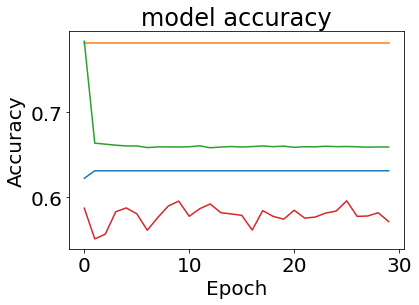

In [43]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [47]:
test_results = model.evaluate(X_axial_test[:300], y_axial_test[:300])
test_results

10/10 [==============================] - 12s 1s/step - loss: 0.5606 - accuracy: 0.8000


[0.5605908632278442, 0.800000011920929]

In [49]:
preds = model.predict(X_axial_test[:300])

predictions = [(0 if i <0.5 else 1) for i in preds]
cm = confusion_matrix(y_pred=predictions, y_true=y_axial_test[:300])

print('Accuracy {}'.format(accuracy_score(y_true=y_axial_test[:300], y_pred=predictions)))

Accuracy 0.8


In [50]:
cm

array([[  0,  60],
       [  0, 240]], dtype=int64)

# CORONAL

In [35]:
X_coronal_train, y_coronal_train = get_slices_per_group_coronal(X_train, y_train)
X_coronal_train = X_coronal_train.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/202] Slices processed 19.
-> [2/202] Slices processed 38.
-> [3/202] Slices processed 57.
-> [4/202] Slices processed 76.
-> [5/202] Slices processed 95.
-> [6/202] Slices processed 114.
-> [7/202] Slices processed 133.
-> [8/202] Slices processed 152.
-> [9/202] Slices processed 171.
-> [10/202] Slices processed 190.
-> [11/202] Slices processed 206.
-> [12/202] Slices processed 225.
-> [13/202] Slices processed 244.
-> [14/202] Slices processed 263.
-> [15/202] Slices processed 279.
-> [16/202] Slices processed 298.
-> [17/202] Slices processed 317.
-> [18/202] Slices processed 336.
-> [19/202] Slices processed 355.
-> [20/202] Slices processed 374.
-> [21/202] Slices processed 393.
-> [22/202] Slices processed 412.
-> [23/202] Slices processed 431.
-> [24/202] Slices processed 450.
-> [25/202] Slices processed 469.
-> [26/202] Slices processed 488.
-> [27/202] Slices processed 507.
-> [28/202] Slices processed 526.
-> [29/202] Slices processed 545.
-> [30/202] Slices processed

C:\Users\josie\AppData\Local\Temp/ipykernel_2416/3491320886.py:22: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [184/202] Slices processed 3454.
-> [185/202] Slices processed 3473.
-> [186/202] Slices processed 3492.
-> [187/202] Slices processed 3511.
-> [188/202] Slices processed 3530.
-> [189/202] Slices processed 3549.
-> [190/202] Slices processed 3568.
-> [191/202] Slices processed 3587.
-> [192/202] Slices processed 3606.
-> [193/202] Slices processed 3625.
-> [194/202] Slices processed 3644.
-> [195/202] Slices processed 3663.
-> [196/202] Slices processed 3682.
-> [197/202] Slices processed 3701.
-> [198/202] Slices processed 3720.
-> [199/202] Slices processed 3739.
-> [200/202] Slices processed 3758.
-> [201/202] Slices processed 3777.
-> [202/202] Slices processed 3796.


In [36]:
X_coronal_test, y_coronal_test = get_slices_per_group_coronal(X_test, y_test)
X_coronal_test = X_coronal_test.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/51] Slices processed 19.
-> [2/51] Slices processed 38.
-> [3/51] Slices processed 57.
-> [4/51] Slices processed 76.
-> [5/51] Slices processed 95.
-> [6/51] Slices processed 114.
-> [7/51] Slices processed 133.
-> [8/51] Slices processed 152.
-> [9/51] Slices processed 171.
-> [10/51] Slices processed 190.
-> [11/51] Slices processed 209.
-> [12/51] Slices processed 228.
-> [13/51] Slices processed 247.
-> [14/51] Slices processed 266.
-> [15/51] Slices processed 285.
-> [16/51] Slices processed 304.
-> [17/51] Slices processed 323.
-> [18/51] Slices processed 342.
-> [19/51] Slices processed 361.
-> [20/51] Slices processed 380.
-> [21/51] Slices processed 399.
-> [22/51] Slices processed 418.
-> [23/51] Slices processed 437.
-> [24/51] Slices processed 456.
-> [25/51] Slices processed 475.
-> [26/51] Slices processed 494.
-> [27/51] Slices processed 513.
-> [28/51] Slices processed 532.
-> [29/51] Slices processed 551.
-> [30/51] Slices processed 570.
-> [31/51] Slices proces

In [37]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_coronal_train.shape[0],X_coronal_train.shape[1],X_coronal_train.shape[2],X_coronal_train.shape[3], len(y_coronal_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_coronal_test.shape[0],X_coronal_test.shape[1],X_coronal_test.shape[2],X_coronal_test.shape[3], len(y_coronal_test)))

Train: X:(3796, 224, 224, 1), y: 3796
Test: X:(969, 224, 224, 1), y: 969


# VGG19

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [39]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 128)     0

In [40]:
checkpoint = ModelCheckpoint("vgg19_coronal_15012022_2322.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [41]:
hist = model.fit(X_coronal_train, y_coronal_train, batch_size=1,epochs=50,validation_split=0.2, callbacks=[checkpoint,early])

Epoch 1/50
3036/3036 [==============================] - 4993s 2s/step - loss: 2897.2546 - accuracy: 0.6067 - val_loss: nan - val_accuracy: 0.5750

Epoch 00001: val_accuracy improved from -inf to 0.57500, saving model to vgg19_coronal_15012022_2322.h5
Epoch 2/50
3036/3036 [==============================] - 5065s 2s/step - loss: 0.6720 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 00002: val_accuracy did not improve from 0.57500
Epoch 3/50
3036/3036 [==============================] - 4960s 2s/step - loss: 0.6719 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 00003: val_accuracy did not improve from 0.57500
Epoch 4/50
3036/3036 [==============================] - 5106s 2s/step - loss: 0.6721 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 00004: val_accuracy did not improve from 0.57500
Epoch 5/50
3036/3036 [==============================] - 5093s 2s/step - loss: 0.6716 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 00

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
model.load_weights("./vgg19_coronal.h5")
test_results = model.evaluate(X_coronal_test, y_coronal_test)
test_results

# Sagital

In [42]:
X_sagital_train, y_sagital_train = get_slices_per_group_sagital(X_train, y_train)
X_sagital_train = X_sagital_train.reshape(-1, X_sagital_train.shape[1], X_sagital_train.shape[2], 1)

-> [1/202] Slices processed 15.
-> [2/202] Slices processed 34.
-> [3/202] Slices processed 53.
-> [4/202] Slices processed 72.
-> [5/202] Slices processed 91.
-> [6/202] Slices processed 110.
-> [7/202] Slices processed 129.
-> [8/202] Slices processed 148.
-> [9/202] Slices processed 167.
-> [10/202] Slices processed 186.
-> [11/202] Slices processed 202.
-> [12/202] Slices processed 221.
-> [13/202] Slices processed 240.
-> [14/202] Slices processed 259.
-> [15/202] Slices processed 275.
-> [16/202] Slices processed 294.
-> [17/202] Slices processed 313.
-> [18/202] Slices processed 332.
-> [19/202] Slices processed 351.
-> [20/202] Slices processed 370.
-> [21/202] Slices processed 389.
-> [22/202] Slices processed 408.
-> [23/202] Slices processed 427.
-> [24/202] Slices processed 446.
-> [25/202] Slices processed 465.
-> [26/202] Slices processed 484.
-> [27/202] Slices processed 503.
-> [28/202] Slices processed 522.
-> [29/202] Slices processed 541.
-> [30/202] Slices processed

C:\Users\josie\AppData\Local\Temp/ipykernel_2416/3491320886.py:22: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [184/202] Slices processed 3450.
-> [185/202] Slices processed 3469.
-> [186/202] Slices processed 3488.
-> [187/202] Slices processed 3507.
-> [188/202] Slices processed 3526.
-> [189/202] Slices processed 3545.
-> [190/202] Slices processed 3564.
-> [191/202] Slices processed 3583.
-> [192/202] Slices processed 3602.
-> [193/202] Slices processed 3621.
-> [194/202] Slices processed 3640.
-> [195/202] Slices processed 3659.
-> [196/202] Slices processed 3678.
-> [197/202] Slices processed 3697.
-> [198/202] Slices processed 3716.
-> [199/202] Slices processed 3735.
-> [200/202] Slices processed 3754.
-> [201/202] Slices processed 3773.
-> [202/202] Slices processed 3792.


In [ ]:
X_sagital_test, y_sagital_test = get_slices_per_group_sagital(X_test, y_test)
X_sagital_test = X_sagital_test.reshape(-1, X_sagital_train.shape[1], X_sagital_train.shape[2], 1)

In [ ]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_sagital_train.shape[0],X_sagital_train.shape[1],X_sagital_train.shape[2],X_sagital_train.shape[3], len(y_sagital_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_sagital_test.shape[0],X_sagital_test.shape[1],X_sagital_test.shape[2],X_sagital_test.shape[3], len(y_sagital_test)))

# VGG19

In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [49]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 128)    

In [50]:
checkpoint = ModelCheckpoint("vgg19_sagital_16012022_1749.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
hist = model.fit(X_coronal_train, y_coronal_train, batch_size=1,epochs=50,validation_split=0.2, callbacks=[checkpoint,early])

Epoch 1/50
3036/3036 [==============================] - 4981s 2s/step - loss: 12.2045 - accuracy: 0.6041 - val_loss: nan - val_accuracy: 0.5750

Epoch 00001: val_accuracy improved from -inf to 0.57500, saving model to vgg19_sagital_16012022_1749.h5
Epoch 2/50
3036/3036 [==============================] - 4972s 2s/step - loss: 0.6718 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 00002: val_accuracy did not improve from 0.57500
Epoch 3/50
3036/3036 [==============================] - 4754s 2s/step - loss: 0.6720 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 00003: val_accuracy did not improve from 0.57500
Epoch 4/50
3036/3036 [==============================] - 4567s 2s/step - loss: 0.6720 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 00004: val_accuracy did not improve from 0.57500
Epoch 5/50
3036/3036 [==============================] - 4571s 2s/step - loss: 0.6719 - accuracy: 0.6057 - val_loss: nan - val_accuracy: 0.5750

Epoch 0000

#EXTRA

In [ ]:
arr_reshaped = cv2.resize(arr[:, : , 100], (224, 224), interpolation=cv2.INTER_CUBIC)
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

In [33]:
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

NameError: name 'arr_reshaped' is not defined

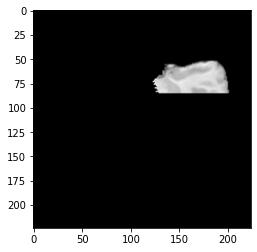

In [15]:
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(arr_reshaped, cmap="gray") 

plt.show()

In [5]:
BUY_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/BUY/*/ex_*.nii.gz"))  #68 files
EAT_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/EAT/*/ex_*.nii.gz")) #81files
GAMBLE_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/GAMBLE/*/ex_*.nii.gz"))  #7 files
SEX_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/SEX/*/ex_*.nii.gz"))  #42 files

PD_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/PD/*/ex_*.nii.gz"))  #100 files

NameError: name 'glob' is not defined

In [6]:
print(len(BUY_file_paths), BUY_file_paths[:3])
print(len(EAT_file_paths), EAT_file_paths[:3])
print(len(GAMBLE_file_paths), GAMBLE_file_paths[:3])
print(len(SEX_file_paths), SEX_file_paths[:3])

print(len(PD_file_paths), PD_file_paths[:3])

NameError: name 'BUY_file_paths' is not defined

In [3]:
import os
import shutil
import subprocess

In [4]:
destiny = "E:/ESPOL/integradora/desorders/PREPROCESSED/" + "BUY/"

for file in BUY_file_paths:
    id = file.split("\\")[1]
    shutil.copyfile(file, destiny + id + ".nii.gz")

NameError: name 'BUY_file_paths' is not defined

# Evaluate

In [42]:
#Axial assamble

batch_size = 10
epochs = 1000
dropout_rate = 0.2

model = Sequential()
model.add(Flatten(input_shape=X_axial3c_test.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

checkpoint = ModelCheckpoint("vgg19_axial3c_15022022_01231.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)
model.load_weights('vgg19_axial3c_15022022_01231.h5') #Load Weights
print('Loading The Model')

c:\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Loading The Model


In [39]:
model.load_weights("./vgg19_axial3c_17012022_1741.h5")

In [ ]:
test_results = model.evaluate(X_test, y_test)
test_results

In [42]:
X_test

['./PREPROCESSED/EAT\\4108.nii.gz',
 './PREPROCESSED/PD\\3819.nii.gz',
 './PREPROCESSED/EAT\\3124.nii.gz',
 './PREPROCESSED/BUY\\40693.nii.gz',
 './PREPROCESSED/EAT\\3952.nii.gz',
 './PREPROCESSED/PD\\3753.nii.gz',
 './PREPROCESSED/PD\\3633.nii.gz',
 './PREPROCESSED/PD\\3666.nii.gz',
 './PREPROCESSED/PD\\3365.nii.gz',
 './PREPROCESSED/EAT\\3530.nii.gz',
 './PREPROCESSED/PD\\3026.nii.gz',
 './PREPROCESSED/EAT\\3624.nii.gz',
 './PREPROCESSED/EAT\\4064.nii.gz',
 './PREPROCESSED/PD\\3419.nii.gz',
 './PREPROCESSED/BUY\\3290.nii.gz',
 './PREPROCESSED/PD\\3415.nii.gz',
 './PREPROCESSED/BUY\\42860.nii.gz',
 './PREPROCESSED/PD\\3830.nii.gz',
 './PREPROCESSED/BUY\\3522.nii.gz',
 './PREPROCESSED/PD\\3012.nii.gz',
 './PREPROCESSED/EAT\\3002.nii.gz',
 './PREPROCESSED/BUY\\41521.nii.gz',
 './PREPROCESSED/EAT\\51518.nii.gz',
 './PREPROCESSED/PD\\3778.nii.gz',
 './PREPROCESSED/BUY\\73673.nii.gz',
 './PREPROCESSED/PD\\3129.nii.gz',
 './PREPROCESSED/EAT\\41664.nii.gz',
 './PREPROCESSED/PD\\3325.nii.gz',

In [44]:
preds = model.predict(X_test)

predictions = [(0 if i <0.5 else 1) for i in preds]
cm = confusion_matrix(y_pred=predictions, y_true=y_test)

print('Accuracy {}'.format(accuracy_score(y_true=y_test, y_pred=predictions)))

Accuracy 0.9742120343839542


array([[1.99564040e-01],
       [8.12378764e-01],
       [9.99853730e-01],
       [5.04152179e-01],
       [7.63765693e-01],
       [9.99991357e-01],
       [9.99999523e-01],
       [9.70557451e-01],
       [9.98879433e-01],
       [9.93870020e-01],
       [9.99813795e-01],
       [9.85491812e-01],
       [9.33430195e-01],
       [9.99078572e-01],
       [1.00000000e+00],
       [9.99999881e-01],
       [1.15221083e-04],
       [9.01652098e-01],
       [7.20411539e-04],
       [2.79992819e-04],
       [9.99996781e-01],
       [9.97048020e-01],
       [5.34687042e-01],
       [9.99997258e-01],
       [9.98619199e-03],
       [9.99942303e-01],
       [4.33390737e-01],
       [9.99983728e-01],
       [7.83111744e-08],
       [9.95022655e-01],
       [9.98543024e-01],
       [9.99680877e-01],
       [2.22097933e-02],
       [9.25597548e-03],
       [9.94977832e-01],
       [3.26287882e-05],
       [1.26740336e-02],
       [9.99996543e-01],
       [9.63730097e-01],
       [2.29313791e-05],


Confusion Matrix
[[224  10]
 [  8 456]]


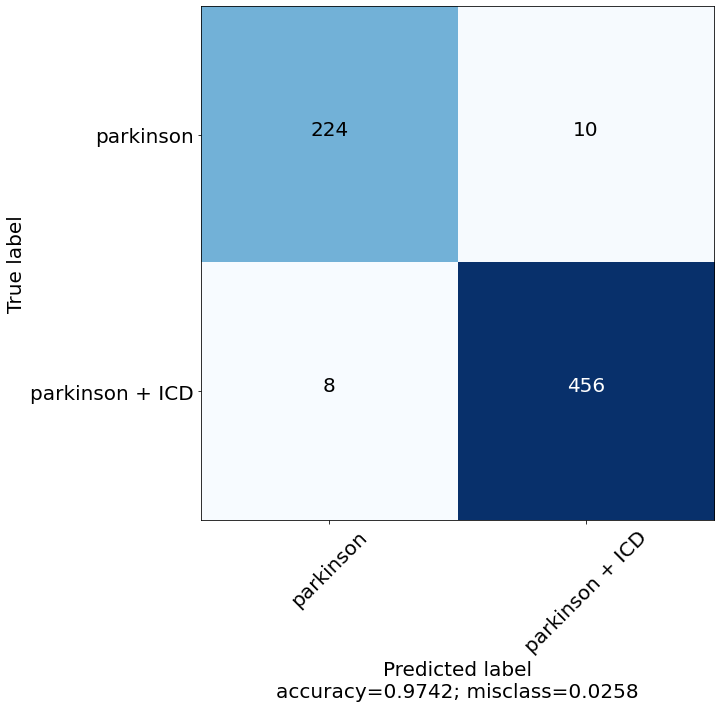

In [45]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = ["parkinson + ICD", 'parkinson']

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_marix.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')